In [38]:
from sparse_rrt.planners import SST
from env.cartpole_obs import CartPoleObs
from env.cartpole import CartPole
from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from tools.pcd_generation import rectangle_pcd

obs_list = []
width = 4.
near = width * 1.2
H = 0.5
L = 2.5
print('generating obs...')
for i in range(1):
    obs_single = []
    for j in range(6):
        low_h = - width/2 - L
        high_h = width/2 + L
        '''
        make sure the obstacle does not block the pole entirely
        by making sure the fixed point of the pole is not in the obs
        hence the valid range for y axis is:
        H - low_h ~ H - width/2, H + width/2 ~ H + high_h
        '''
        while True:
            # first randomly see if it is left or right
            side = np.random.randint(low=0, high=2)
            print(side)
            # 0: left, 1: right
            if side == 0:
                obs = np.random.uniform(low=[-20, H+low_h], high=[20, H-width/2])
            else:
                obs = np.random.uniform(low=[-20, H+width/2], high=[20, H+high_h])
            # see if it is cluttered enough by making sure obstacles can't be
            # too close
            too_near = False
            for k in range(len(obs_single)):
                if np.linalg.norm(obs-obs_single[k]) < near:
                    too_near = True
                    break
            if not too_near:
                break
            
        obs_single.append(obs)
    obs_single = np.array(obs_single)
    obs_list.append(obs_single)
obs_list = np.array(obs_list)
# convert from obs to point cloud
obc_list = rectangle_pcd(obs_list, 4., 1400)
print('generated.')
print(obs_list.shape)

# Create custom system
#obs_list = [[-10., -3.],
#            [0., 3.],
#            [10, -3.]]
obs_list = obs_list[0]


generating obs...
1
0
0
0
1
0
0
1
0
0
1
0
0
generated.
(1, 6, 2)


In [44]:

#obs_list = np.array(obs_list)
system = standard_cpp_systems.CartPoleObs(obs_list, 4.)
#system = CartPoleObs(obs_list)
# Create SST planner
min_time_steps = 10
max_time_steps = 200
integration_step = 0.002
max_iter = 100000
goal_radius=1.5
random_seed=0
sst_delta_near=2.0
sst_delta_drain=1.2

low = []
high = []
state_bounds = system.get_state_bounds()
for i in range(len(state_bounds)):
    low.append(state_bounds[i][0])
    high.append(state_bounds[i][1])
    
start = np.random.uniform(low=low, high=high)
end = np.random.uniform(low=low, high=high)


start[1] = 0.
start[3] = 0.
end[1] = 0.
end[3] = 0.
planner = SST(
    state_bounds=system.get_state_bounds(),
    control_bounds=system.get_control_bounds(),
    distance=system.distance_computer(),
    start_state=start,
    goal_state=end,
    goal_radius=goal_radius,
    random_seed=0,
    sst_delta_near=sst_delta_near,
    sst_delta_drain=sst_delta_drain
)

    
# Run planning and print out solution is some statistics every few iterations.
time0 = time.time()
for iteration in range(max_iter):
    #if iteration % 50 == 0:
    #    # from time to time use the goal
    #    sample = end
    #    planner.step_with_sample(system, sample, 20, 200, 0.002)
    #else:
    planner.step(system, min_time_steps, max_time_steps, integration_step)
    #    #sample = np.random.uniform(low=low, high=high)
    #print('iteration: %d' % (iteration))
    # interation: 0.002
    #planner.step_with_sample(system, sample, 2, 20, 0.01)
    
    #if iteration % 100 == 0:
solution = planner.get_solution()
print("Solution: %s, Number of nodes: %s" % (planner.get_solution(), planner.get_number_of_nodes()))

print('time spent: %f' % (time.time() - time0))
assert solution is not None

Solution: (array([[18.65538711,  0.        , -0.77955624,  0.        ],
       [19.6542324 ,  6.19902309, -0.88171407, -0.59453115],
       [20.37761409,  8.01411765, -0.94758839, -0.69102108],
       [22.34971369, 11.92172868, -1.09965237, -0.80890074],
       [25.13372933, 11.30332671, -1.20681687, -0.07972395],
       [28.1047857 ,  3.41611459, -0.84701017,  2.        ],
       [28.39531093, -1.78627894, -0.10701017,  2.        ],
       [28.29285675, -0.20990722,  0.07062545,  1.52774789],
       [28.58247155,  2.63592959,  0.32410441,  0.53394455],
       [28.96807974,  1.15231415,  0.45436783,  0.72286078]]), array([[ 274.08914508],
       [ 263.81241629],
       [ 298.30069234],
       [ -20.97489156],
       [-256.27495549],
       [-134.1988562 ],
       [ 178.45256774],
       [ 123.81905068],
       [-100.29579122]]), array([0.322, 0.102, 0.198, 0.24 , 0.394, 0.37 , 0.1  , 0.242, 0.204])), Number of nodes: 2161
time spent: 10.593559


In [40]:
states, actions, costs = solution
print(states.shape)
print(actions.shape)

(32, 4)
(31, 1)


In [41]:
# visualize the path
"""
Given a list of states, render the environment
"""
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import HTML
from visual.visualizer import Visualizer



class CartPoleVisualizer(Visualizer):
    def __init__(self, system, params):
        super(CartPoleVisualizer, self).__init__(system, params)
        self.dt = 0.05

    def _init(self):
        # clear the current ax
        ax = plt.gca()
        ax.clear()
        # add patches
        state = self.states[0]
        self.pole = patches.Rectangle((state[0]-self.params['pole_w']/2,self.params['cart_h']),\
                                       self.params['pole_w'],self.params['pole_l'],\
                                      linewidth=.5,edgecolor='red',facecolor='red')
        self.cart = patches.Rectangle((state[0]-self.params['cart_w']/2,0),\
                                       self.params['cart_w'],self.params['cart_h'],\
                                      linewidth=.5,edgecolor='blue',facecolor='blue')
        self.recs = []
        self.recs.append(self.pole)
        self.recs.append(self.cart)
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.pole.set_transform(t)
        ax.add_patch(self.pole)
        ax.add_patch(self.cart)
        return self.recs
    def _animate(self, i):
        ax = plt.gca()
        ax.set_xlim(-40, 40)
        ax.set_ylim(-20, 20)
        state = self.states[i]
        self.recs[0].set_xy((state[0]-self.params['pole_w']/2,self.params['cart_h']))
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[0].set_transform(t)
        self.recs[1].set_xy((state[0]-self.params['cart_w']/2,params['cart_h']))
        # print location of cart
        return self.recs


 
    def animate(self, states, actions, obstacles):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''
        # transform the waypoint states and actions into trajectory
        traj = []
        for i in range(len(states)-1):
            print('state: %d, remaining: %d' % (i, len(states)-i))
            s = states[i]
            action = actions[i]
            sT = states[i+1]
            # propogate until reaching next state
            while True:
                traj.append(s)
                #print("porpagating...")
                #print(s)
                #print('st:')
                #print(sT)
                s = self.system.propagate(s, action, 1, self.params['integration_step'])
                if np.linalg.norm(s-sT) == 0.:
                    break
        traj = np.array(traj)
        print("animating...")
        # animate
        self.states = traj
        self.obs = obstacles
        print(len(self.states))
        ani = animation.FuncAnimation(plt.gcf(), self._animate, range(1, len(self.states)),
                                      interval=self.dt*10, blit=True, init_func=self._init,
                                      repeat=True)
        return ani


state: 0, remaining: 32
state: 1, remaining: 31
state: 2, remaining: 30
state: 3, remaining: 29
state: 4, remaining: 28
state: 5, remaining: 27
state: 6, remaining: 26
state: 7, remaining: 25
state: 8, remaining: 24
state: 9, remaining: 23
state: 10, remaining: 22
state: 11, remaining: 21
state: 12, remaining: 20
state: 13, remaining: 19
state: 14, remaining: 18
state: 15, remaining: 17
state: 16, remaining: 16
state: 17, remaining: 15
state: 18, remaining: 14
state: 19, remaining: 13
state: 20, remaining: 12
state: 21, remaining: 11
state: 22, remaining: 10
state: 23, remaining: 9
state: 24, remaining: 8
state: 25, remaining: 7
state: 26, remaining: 6
state: 27, remaining: 5
state: 28, remaining: 4
state: 29, remaining: 3
state: 30, remaining: 2
animating...
3598


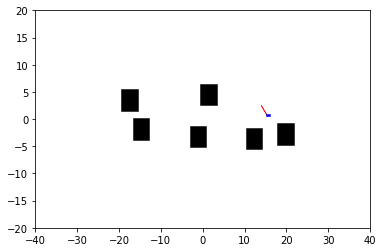

In [42]:
params = {}
params['pole_l'] = 2.5
params['pole_w'] = 0.1
params['cart_w'] = 1.
params['cart_h'] = 0.5
params['obs_w'] = 4
params['obs_h'] = 4
params['integration_step'] = 0.002
system = CartPole(obs_list)
vis = CartPoleVisualizer(system, params)
states, actions, costs = solution
anim = vis.animate(states, actions, obs_list)
HTML(anim.to_html5_video())

In [43]:
print(obs_list)

[[-17.5506367    3.48127966]
 [ 12.24373442  -3.58442395]
 [ -1.12852535  -3.19533116]
 [-14.77111333  -1.83850489]
 [  1.38583476   4.52791837]
 [ 19.77008484  -2.8085307 ]]
